# Proyek Klasifikasi Gambar: [Intel Image Classification Dataset]
- **Nama:** [Jocelyn Nathaniel Patricktan]
- **Email:** [jocelyn22002@mail.unpad.ac.id]
- **ID Dicoding:** [MC011D5X1268]

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

In [2]:
# Import Library yang Sering Digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [3]:
# Import Library untuk Visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

In [4]:
# Import Library untuk Pembangunan Model
import keras
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [5]:
# Menonaktifkan Peringatan yang Mungkin Muncul
import warnings
warnings.filterwarnings(action="ignore", category=FutureWarning)

In [6]:
# Mencetak Versi Tensorflow yang Sedang Digunakan
print(tf.__version__)

2.19.0


## Data Preparation

### Data Loading

In [7]:
import kagglehub

# Mengunduh Dataset
intel_image = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path ke dataset file:", intel_image)
print("Isi folder dataset:", os.listdir(intel_image))

Path ke dataset file: /kaggle/input/intel-image-classification
Isi folder dataset: ['seg_train', 'seg_pred', 'seg_test']


In [8]:
# Membuat Path untuk ke Direktori Train dan Test
train = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test = "/kaggle/input/intel-image-classification/seg_test/seg_test"

In [9]:
# Menampilkan Kelas pada Dataset
classes = os.listdir(train)
print("Kelas yang terdapat dalam dataset:", classes)

Kelas yang terdapat dalam dataset: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


### Data Preprocessing

#### Split Dataset

In [10]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Membuat Parameter Umum
image_size = (224, 224)
batch_size = 32
seed = 123

# Memuat Dataset Train
train_dst = image_dataset_from_directory(train,
                                         validation_split=0.2, #validasi sebesar 20%
                                         subset="training",
                                         seed=seed,
                                         image_size=image_size,
                                         batch_size=batch_size,
                                         label_mode='categorical')

# Memuat Dataset Validation
val_dst = image_dataset_from_directory(train,
                                       validation_split=0.2,
                                       subset="validation",
                                       seed=seed,
                                       image_size=image_size, batch_size=batch_size, label_mode="categorical")

# Memuat Dataset Test
test_dst = image_dataset_from_directory(test,
                                        seed=seed,
                                        image_size=image_size,
                                        batch_size=batch_size,
                                        label_mode="categorical")

# Debugging dengan Mencetak Informasi Dataset Validation
print("Jumlah batch di dataset validation:", len(val_dst))  #jumlah batch
for images, labels in val_dst.take(1):
    print("Bentuk images:", images.shape)  #bentuk tensor images
    print("Bentuk labels:", labels.shape)  #bentuk tensor labels
    print("Contoh label:", labels[0])  #contoh label

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
Jumlah batch di dataset validation: 88
Bentuk images: (32, 224, 224, 3)
Bentuk labels: (32, 6)
Contoh label: tf.Tensor([0. 0. 0. 1. 0. 0.], shape=(6,), dtype=float32)


In [11]:
# Normalisasi Dataset (Tidak Melakukan Augmentasi)
normalization_dst  = layers.Rescaling(1./255)

train_dst = train_dst.map(lambda x, y: (normalization_dst(x), y))
val_dst = val_dst.map(lambda x, y: (normalization_dst(x), y))
test_dst = test_dst.map(lambda x, y: (normalization_dst(x), y))

## Modelling

In [12]:
# Menginput Transfer Learning
model_base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model_base.trainable = False

# Init Sequential Model
model = Sequential([
    model_base,

    # Convolution Layer dan Pooling Layer
    Conv2D(32, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),

    # Flatten dan Dense Layer
    Flatten(),
    Dense(128, activation="relu"),
    Dense(6, activation="softmax")])

# Compile Model
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Kesimpulan Arsitektur Model
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,664,422 (10.16 MB)

 Trainable params: 406,438 (1.55 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [13]:
# Mendefinisikan Callbacks
early_stopping = EarlyStopping(monitor="val_loss",  mode="min", patience=10, restore_best_weights=True)

# Fitting / Training Model dengan Callbacks
history = model.fit(train_dst, validation_data=val_dst,  epochs=20, callbacks=[early_stopping], verbose=2)

Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 979s 3s/step - accuracy: 0.8122 - loss: 0.5631 - val_accuracy: 0.8984 - val_loss: 0.2821
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 917s 3s/step - accuracy: 0.9185 - loss: 0.2199 - val_accuracy: 0.8977 - val_loss: 0.2822
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 833s 2s/step - accuracy: 0.9398 - loss: 0.1506 - val_accuracy: 0.8991 - val_loss: 0.3165
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 894s 3s/step - accuracy: 0.9594 - loss: 0.1061 - val_accuracy: 0.9006 - val_loss: 0.3867
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 865s 2s/step - accuracy: 0.9739 - loss: 0.0722 - val_accuracy: 0.8984 - val_loss: 0.4099
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 889s 3s/step - accuracy: 0.9853 - loss: 0.0433 - val_accuracy: 0.8974 - val_loss: 0.4692
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 929s 3s/step - accuracy: 0.9838 - loss: 0.0425 - val_accuracy: 0.8974 - val_loss: 0.5133
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 887s 2s/step - accuracy: 0.9841 - loss: 0.0487 - val_accu

## Evaluasi dan Visualisasi

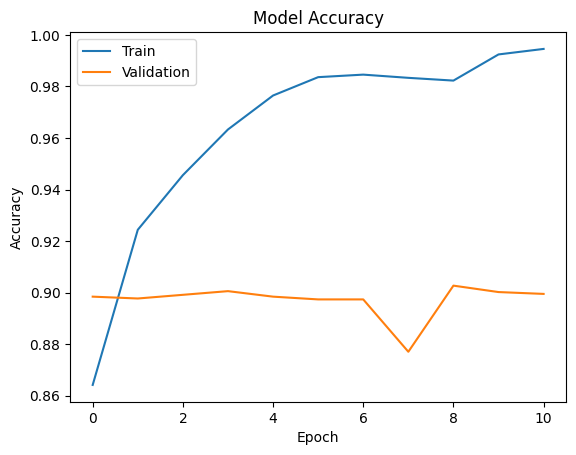

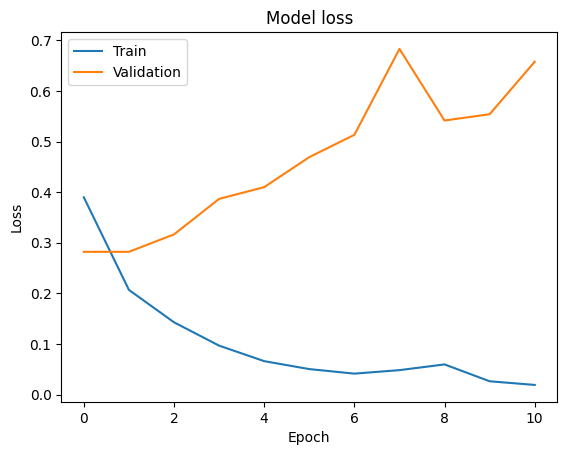

In [17]:
# Plot Akurasi
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train Accuracy", "Validation Accuracy"], loc="upper left")
plt.show()

# Plot Loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss", "Validation Loss"], loc="upper left")
plt.show()

In [18]:
# Evalusasi Model pada Dataset Test
loss, accuracy = model.evaluate(test_dst)
print("Akurasi pada dataset test sebesar:", accuracy)

94/94 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.8987 - loss: 0.2696
Loss: 0.2683517336845398
Accuracy: 0.9043333530426025
Akurasi pada dataset test sebesar: 0.9043333530426025


## Konversi Model

### **SavedModel**

In [30]:
# Menyimpan Model dalam Direktori SavedModel
saved_model_path = "saved_model/"
tf.saved_model.save(model, saved_model_path)

# Menampilkan Isi Direktori
for filename in os.listdir(saved_model_path):
  print(filename)

fingerprint.pb
saved_model.pb
variables
assets


### **TF-Lite**

In [31]:
# Memuat Direktori SavedModel
saved_model_dir = "saved_model/"

# Mengonversi Model ke TF_Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Menyimpan Model TF-Lite ke File
tflite_model_dir = "model.tfite"
with open(tflite_model_dir, "wb") as f:
  f.write(tflite_model)

# Menggunakan Label Kelas
label_classes = ["mountain", "street", "buildings", "sea", "forest", "glacier"]

# Menyimpan Label ke File
with open("labels.txt", "w") as f:
  for label in label_classes:
    f.write(f"{label}\n")

### **TFJS**

In [32]:
# Mengonversi dan Menyimpan Model ke TFJS
!pip install tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model saved_model/ tfjs_model/

2025-04-27 14:13:06.486626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745763186.521805  141985 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745763186.532332  141985 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-27 14:13:16.598320: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1745763198.800133  141985 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

## Inference (Optional)